<a href="https://colab.research.google.com/github/AdiA32/ImageAesthetic/blob/main/Aesthetic_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [3]:
# Installs

!pip install --upgrade google-cloud-vision
!pip install mysql-connector-python-rf
# !pip install -qU transformers torch datasets gdcm pydicom pinecone-client
!pip install -qU gdcm pydicom pinecone-client datasets
!pip install pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.1/444.1 kB 5.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 132.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql-connector-python-rf: filename=mysql_connector_python_rf-2.2.2-cp310-cp310-linux_x86_64.whl size=249460 sha256=a770ad713e42f2e6a5bb733f2dc6c0d65ad44c74d6764ccd92009b2c12db5d35
  Stored in directory: /root/.cache/pip/wheels/6e/7d/63/f1e829bfbd126cd52625ed99c60ae9f09f52c7b6a76dec070c
Successfully built mysql-connector-python-rf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [5]:
# Google Imports

import os
from google.cloud import vision
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine, text

# Embedding Imports
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import pinecone
import IPython.display as display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

import torchvision.transforms as T

import json
import os
import pinecone
import openai
import requests
import numpy as np
import itertools
import torch
import random
import matplotlib.pyplot as plt
# from dotenv import load_dotenv
from bs4 import BeautifulSoup
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
from urllib.parse import urlparse
from pathlib import Path
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from openai import OpenAI
from PIL import Image
from imageio import imread
from io import BytesIO
from google.colab import userdata


/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
# Initialize Pinecone
pinecone.init(
    api_key=userdata.get('PINECONE_API_KEY'),
    environment="gcp-starter"
)

# Create a Pinecone index
index_name = 'aesthetic'
if index_name not in pinecone.list_indexes():
    pinecone.create_index(index_name, dimension=512)

# Connect to your index
index = pinecone.Index(index_name)




# #Need openaikey
# openai.api_key = userdata.get("OPENAI_API_KEY")

# client = OpenAI(userdata.get("OPENAI_API_KEY"))
# model_id = "openai/clip-vit-base-patch32"

# processor = CLIPProcessor.from_pretrained(model_id)
# model = CLIPModel.from_pretrained(model_id)

# # move model to device if possible
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# out = model.to(device)

# Create a Dataset of 10 Aesthetics
- Select 10 different fashion aesthetics (e.g., streetwear, vintage, boho, etc.).
- For each aesthetic, gather a minimum of 10 images (5 representing male fashion and 5 representing female fashion).
- Ensure these images are diverse and accurately represent the chosen aesthetic. singles?


In [21]:
styles = [
    "Classic Businesswear",
    "Streetwear",
    "Preppy",
    "Minimalist",
    "Skater",
    "Soft",
    "Athleisure",
    "Boho (Bohemian)",
    "Vintage",
    "Athletic"
]

#added gender so i can build better database
def get_styles(query, gender, num_results=5):
    url = "https://www.googleapis.com/customsearch/v1"

    full_query = f"{query} {gender} fashion"  # Include gender in the query

    params = {
        "q": full_query,
        "cx": userdata.get('GOOGLE_CSE_ID'),
        "key": userdata.get('GOOGLE_API_KEY'),
        "searchType": "image",
        "num": num_results
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return [item["link"] for item in response.json()["items"]]
    else:
        print("Error: ", response.status_code)
        return []

# #calling ^ and getting 5 women and 5 men items for each style
# def get_style_images(styles, num_results_per_gender=5):
#     images = []
#     for style in styles:
#         for gender in ["men", "women"]:
#             try:
#                 temp = get_styles(style, gender, num_results_per_gender)
#             except Exception as e:
#                 print(f"Error occurred for style: {style}, gender: {gender}, error: {e}")
#                 temp = []
#             image = {
#                 "style": style,
#                 "gender": gender,
#                 "images": temp
#             }
#             images.append(image)
#     return images


# def download_images(image, base_folder, verbose=False):
#     style = image['style']
#     images = image['images']
#     style_folder = Path(base_folder) / style

#     # Create the folder for the style if it doesn't exist
#     style_folder.mkdir(parents=True, exist_ok=True)
#     output = []

#     for url in images:
#         try:
#             # Parse the URL to get the image name
#             image_name = Path(urlparse(url).path).name
#             image_path = style_folder / image_name

#             # Download the image
#             response = requests.get(url)
#             if response.status_code == 200:
#                 with open(image_path, 'wb') as file:
#                     file.write(response.content)
#                     output.append({"style": style, "image_name": image_name, "image_path": image_path, "url": url})
#                 if verbose:
#                     print(f"Image saved at {image_path}")
#             else:
#                 print(f"Failed to download {url}")

#         except Exception as e:
#             print(f"Error occurred: {e}")

#     return output

# images = get_style_images(styles)

# for image in images:
#     print(image["style"])
#     for img in image["images"]:
#         print(img)
#     print()


In [23]:
"""
Not all the URLs are valid. This function returns True if the URL is valid. False otherwise.
"""
def check_valid_URLs(image_URL):
    try:
      response = requests.get(image_URL)
      Image.open(BytesIO(response.content))
      return True
    except:
      return False

def get_image(image_URL):
    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    return image

def get_image_caption(image_ID):
    return image_data[image_ID]["caption"]

In [20]:
def get_style_images(styles, num_results_per_gender=5):
    images = []
    for style in styles:
        for gender in ["men", "women"]:
            try:
                temp = get_styles(style, gender, num_results_per_gender)
                for url in temp:
                    images.append({
                        "image_url": url,
                        "caption": f"{gender} {style} fashion"
                    })
            except Exception as e:
                print(f"Error occurred for style: {style}, gender: {gender}, error: {e}")
    return images

# Assuming styles is your list of styles
image_data = get_style_images(styles)

# Create DataFrame
image_data_df = pd.DataFrame(image_data)

image_data_df

,image_url,caption
0,https://m.media-amazon.com/images/I/61aT+97zQW...,men Classic Businesswear fashion
1,https://i.pinimg.com/564x/71/21/4a/71214a29ea3...,men Classic Businesswear fashion
2,https://m.media-amazon.com/images/I/51ncJbLMva...,men Classic Businesswear fashion
3,https://ae01.alicdn.com/kf/S4765e92d7e5544aca6...,men Classic Businesswear fashion
4,https://i.pinimg.com/736x/78/aa/34/78aa34f62dc...,men Classic Businesswear fashion
...,...,...
95,https://m.media-amazon.com/images/I/61uTpoyOTZ...,women Athletic fashion
96,https://www.gastongazette.com/gcdn/authoring/2...,women Athletic fashion
97,https://i.pinimg.com/736x/86/5a/dc/865adcfb82c...,women Athletic fashion
98,https://m.media-amazon.com/images/I/61cDrEbWHA...,women Athletic fashion


In [24]:
# are urls valid?
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)
image_data_df

,image_url,caption,is_valid
0,https://m.media-amazon.com/images/I/61aT+97zQW...,men Classic Businesswear fashion,True
1,https://i.pinimg.com/564x/71/21/4a/71214a29ea3...,men Classic Businesswear fashion,True
2,https://m.media-amazon.com/images/I/51ncJbLMva...,men Classic Businesswear fashion,True
3,https://ae01.alicdn.com/kf/S4765e92d7e5544aca6...,men Classic Businesswear fashion,True
4,https://i.pinimg.com/736x/78/aa/34/78aa34f62dc...,men Classic Businesswear fashion,True
...,...,...,...
95,https://m.media-amazon.com/images/I/61uTpoyOTZ...,women Athletic fashion,True
96,https://www.gastongazette.com/gcdn/authoring/2...,women Athletic fashion,True
97,https://i.pinimg.com/736x/86/5a/dc/865adcfb82c...,women Athletic fashion,True
98,https://m.media-amazon.com/images/I/61cDrEbWHA...,women Athletic fashion,True


In [30]:
# keep only the valid images
image_data_df = image_data_df[image_data_df['is_valid']]

add images themselves

In [32]:
# Function to safely load an image from a URL (updated)
def get_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

# Assuming image_data_df is your existing DataFrame with image_url
image_data_df["image"] = image_data_df["image_url"].apply(get_image)


Error loading image from https://www.yourcoffeebreak.co.uk/wp-content/uploads/d9a65be8051b1c25035c63728aea888f.jpg: 403 Client Error: Forbidden for url: https://www.yourcoffeebreak.co.uk/wp-content/uploads/d9a65be8051b1c25035c63728aea888f.jpg


<ipython-input-32-832be070072c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data_df["image"] = image_data_df["image_url"].apply(get_image)


In [33]:
image_data_df

,image_url,caption,is_valid,image
0,https://m.media-amazon.com/images/I/61aT+97zQW...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,https://i.pinimg.com/564x/71/21/4a/71214a29ea3...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,https://m.media-amazon.com/images/I/51ncJbLMva...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,https://ae01.alicdn.com/kf/S4765e92d7e5544aca6...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,https://i.pinimg.com/736x/78/aa/34/78aa34f62dc...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
...,...,...,...,...
95,https://m.media-amazon.com/images/I/61uTpoyOTZ...,women Athletic fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
96,https://www.gastongazette.com/gcdn/authoring/2...,women Athletic fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
97,https://i.pinimg.com/736x/86/5a/dc/865adcfb82c...,women Athletic fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...
98,https://m.media-amazon.com/images/I/61cDrEbWHA...,women Athletic fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...


men Streetwear fashion


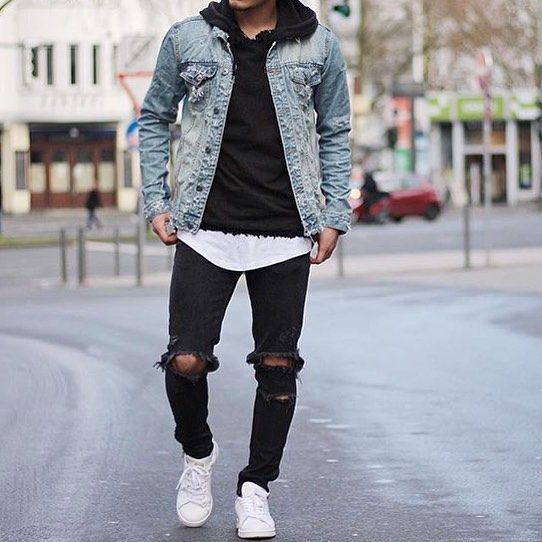

In [36]:
print(image_data_df.iloc[10]['caption'])
image_data_df.iloc[10]["image"]

# Create Embeddings Using OpenAI GPT-4V (Turbo Preview Model) and Upsert to Pinecone
- Use the OpenAI GPT-4V (Turbo Preview model) to generate embeddings for each image. This model can create rich, descriptive embeddings that capture the essence of the images.
- Once the embeddings are generated, upsert (update or insert) them into your Pinecone index along with relevant metadata (like aesthetic type, gender representation, etc.).


Notes:
Embeddings, in the context of machine learning and particularly with your project involving OpenAI's GPT-4V and Pinecone, are a way of representing complex data, like images, in a form that a computer can understand and process efficiently. Here’s a more detailed explanation:

### What Are Embeddings?

1. **Numerical Representations**: Embeddings are numerical representations of data in a high-dimensional space. For images, this means converting the visual content into a list (or vector) of numbers.

2. **Capturing Essence**: These numerical vectors aim to capture the essence or key features of the data. For an image, this might include color schemes, shapes, textures, or even more abstract concepts like the style or mood of the image.

3. **Dimensionality Reduction**: Embeddings often involve reducing the dimensionality of the original data. An image, which is essentially a large array of pixel values, is transformed into a much smaller vector that still retains the important information.

### How Do They Work in Your Project?

In your project, you use OpenAI's GPT-4V to generate embeddings for images. Here's how that fits in:

1. **Image Processing**: When you pass an image to OpenAI's GPT-4V model, the model processes the image and extracts its key features.

2. **Vector Creation**: The model then represents these features as a vector of numbers. This vector is the "embedding" of the image.

3. **Uses of Embeddings**: These embeddings can be used for various purposes, such as:
   - **Similarity Comparison**: Comparing vectors to find similar images (images with similar vectors are likely to be visually or stylistically similar).
   - **Indexing and Retrieval**: In Pinecone, you store these embeddings so that you can later search through them efficiently. When you query the Pinecone index with an embedding, it retrieves items with similar embeddings.

### Why Use Embeddings?

1. **Efficiency**: Dealing with raw images directly is often computationally expensive and inefficient. Embeddings reduce the complexity of the data while retaining the essential information.

2. **Machine Learning Readiness**: Embeddings are a form of feature extraction, making the data ready for machine learning models, which typically work with numbers.

3. **Versatility**: The same embedding technique can be used for different types of data (like text, images, and audio), allowing for consistent processing and analysis methods.

### Conclusion

In summary, in your project, embeddings serve as a bridge between the rich, complex world of visual data and the numerical realm where machine learning algorithms operate. They allow you to efficiently store, search, and analyze images based on their content.

Retard terms:
In simpler terms, embeddings are like a special code that represents something complex in a way that computers can understand and work with easily.

Imagine you have a bunch of photos, and you want a computer to sort them based on their style. Photos are complicated — they have lots of colors, shapes, and details. A computer can't just look at a photo and understand it like we do. So, we turn each photo into an embedding, which is like a unique fingerprint for each photo.

Here's how it works:

1. **Turning Photos into Numbers**: A computer program looks at a photo and picks out its most important features, like colors, patterns, and shapes. Then, it turns these features into a list of numbers. This list of numbers is the embedding.

2. **Comparing Photos**: Now, each photo has its own list of numbers. The computer can easily compare these lists to see which photos are similar. Photos with similar lists of numbers are likely to have similar styles.

3. **Storing and Searching**: We can store these lists of numbers in a system. Later, if we want to find photos with a certain style, the computer can quickly search through these numbers and find what we're looking for.

In your project, you're using a special tool from OpenAI to create these number lists for each photo. Then, you use another tool called Pinecone to store and search through these lists. This makes it easier to organize and find photos based on their style!

In [19]:
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

open ai version no need to run

In [40]:
def get_model_info(model_ID, device):
  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)
  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)
  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)
  # Return model, processor & tokenizer
  return model, processor, tokenizer

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"
model, processor, tokenizer = get_model_info(model_ID, device)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Create Embeddings: Text and Image Embeddings

## Text Embeddings

In [41]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [42]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df

In [43]:
image_data_df = get_all_text_embeddings(image_data_df, "caption")

<ipython-input-42-9087b55f826e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)


In [44]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings
0,https://m.media-amazon.com/images/I/61aT+97zQW...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872..."
1,https://i.pinimg.com/564x/71/21/4a/71214a29ea3...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872..."
2,https://m.media-amazon.com/images/I/51ncJbLMva...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872..."
3,https://ae01.alicdn.com/kf/S4765e92d7e5544aca6...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872..."
4,https://i.pinimg.com/736x/78/aa/34/78aa34f62dc...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872..."


## Image Embeddings

In [56]:
#updated for handling errors
def get_single_image_embedding(my_image):
    if my_image is None:
        return None

    image = processor(
        text=None,
        images=my_image,
        return_tensors="pt"
    )["pixel_values"].to(device)

    embedding = model.get_image_features(image)

    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()

    return embedding_as_np

def get_all_images_embedding(df, img_column):
    embeddings = []
    for img in df[img_column]:
        embedding = get_single_image_embedding(img)
        embeddings.append(embedding)

    df["img_embeddings"] = embeddings
    return df



In [54]:
# Apply the function to your DataFrame
image_data_df = get_all_images_embedding(image_data_df, "image")

<ipython-input-53-e96c405798ea>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["img_embeddings"] = embeddings


In [55]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings,img_embeddings
0,https://m.media-amazon.com/images/I/61aT+97zQW...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872...","[[-0.012862653, 0.61656094, 0.083554246, 0.048..."
1,https://i.pinimg.com/564x/71/21/4a/71214a29ea3...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872...","[[-0.40424854, -0.19809091, -0.23818898, 0.350..."
2,https://m.media-amazon.com/images/I/51ncJbLMva...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872...","[[-0.059224218, 0.0056599677, 0.02003967, -0.2..."
3,https://ae01.alicdn.com/kf/S4765e92d7e5544aca6...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872...","[[-0.31437808, 0.19919759, 0.001432851, 0.4156..."
4,https://i.pinimg.com/736x/78/aa/34/78aa34f62dc...,men Classic Businesswear fashion,True,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[-0.26280436, 0.28302607, 0.23329808, -0.0872...","[[-0.30597422, 0.19280727, -0.04696708, -0.229..."


In [60]:
(image_data_df.img_embeddings == None).sum()

0

## Upsert to pinecone

In [ ]:
def upsert_to_pinecone(id, embedding, metadata):
    """
    Upserts data to a Pinecone index.

    :param id: A unique identifier for the data.
    :param embedding: The embedding vector.
    :param metadata: Additional metadata to store with the embedding.
    """
    index.upsert(vectors={id: (embedding, metadata)})


# Write a Query Function
Develop a function that takes an image as input. This function should use Visual Question Answering (VQA) techniques to analyze the image.
The function should classify the aesthetic of the outfit in the image based on its visual characteristics.
Utilize machine learning models or AI services capable of understanding fashion-related queries for this purpose.


cool idea: show pic of outfit i am wearing and get aesthetic?

In [ ]:
#hugging face - vqa
def classify_outfit_aesthetic(image_path, api_key):
    """
    Classifies the aesthetic of an outfit in an image.

    :param image_path: Path to the image file.
    :param api_key: API key for the image analysis service.
    :return: Predicted aesthetic of the outfit.
    """
    # Load the image
    with open(image_path, 'rb') as image_file:
        image_data = image_file.read()

    # Prepare the request for the API
    # This part varies depending on the specific API you're using
    headers = {'Authorization': f'Bearer {api_key}'}
    payload = {'image': image_data}  # Adjust this according to the API's requirements

    # Send the request to the API
    response = requests.post('API_ENDPOINT', headers=headers, data=payload)

    # Process the response
    # The processing here will depend on the structure of the response from the API
    if response.status_code == 200:
        analysis_result = response.json()
        # Extract the relevant information from the analysis_result to determine the aesthetic
        # This might involve looking for specific keywords or features
        aesthetic = extract_aesthetic_from_result(analysis_result)
        return aesthetic
    else:
        print(f"Error in API call: {response.status_code}")
        return None

def extract_aesthetic_from_result(result):
    """
    Extracts the aesthetic from the analysis result.

    :param result: The result from the image analysis API.
    :return: The determined aesthetic.
    """
    # Implement logic to analyze the result and determine the aesthetic
    # This could be based on identified objects, colors, styles, etc.
    # For example:
    if 'vintage' in result['description']:
        return 'Vintage'
    elif 'sporty' in result['description']:
        return 'Athletic'
    # Add more conditions as needed
    else:
        return 'Unknown'

# Example usage
api_key = 'YOUR_API_KEY'
image_path = 'path/to/your/image.jpg'
aesthetic = classify_outfit_aesthetic(image_path, api_key)
print(f"The outfit's aesthetic is: {aesthetic}")


5. Filter and Retrieve Correct Images from Pinecone Database
Once the aesthetic is determined, use metadata filtering to query your Pinecone index.
Retrieve images that match the classified aesthetic.
Ensure the results are diverse and representative of the aesthetic category.
